In [1]:
import os
from glob import glob

from matplotlib import pyplot as plt
import pandas
import numpy as np
import tqdm

import cartopy
from cartopy import crs as ccrs # A toolkit for map projections

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import pyart
from pyhail import mesh


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [106]:
def plotter_manager(grid_1, grid_2, field, level, report_dict):
    """
    This function is used to generate multiple plots using the plotter() function and simple calls to plot()
    """
    
    #setup figure
    fig = plt.figure(figsize=(12, 12), facecolor='w')
    
    #plot on axis 1 - basic plotting
    ax1 = fig.add_subplot(221, projection= ccrs.PlateCarree())
    ax1.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    plotter(ax1, grid_1, field, level, report_dict, 'NEXRAD MESH SWATH CO 2019-06-18/19')
    
    #plot on axis 2 - basic plotting
    ax2 = fig.add_subplot(222, projection= ccrs.PlateCarree())
    ax2.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    plotter(ax2, grid_2, field, level, report_dict, "CINRAD MESH SWATH CO 2019-06-18/19")
    
    #plot on axis 3 - compare mesh from two retrievals
    ax3 = fig.add_subplot(223)
    mesh_1 = grid_1.fields['MESH']['data'][0,:,:].flatten()
    mesh_2 = grid_2.fields['MESH']['data'][0,:,:].flatten()
    #fitting mesh_1 vs mesh_2
    regr = LinearRegression()
    regr.fit(mesh_1.reshape(-1, 1), mesh_2) #, sample_weight=sample_weight)
    mesh_1_test = np.linspace(0,100,100)
    mesh_2_test = np.linspace(0,100,100)
    mesh_2_pred = regr.predict(mesh_1.reshape(-1, 1))
    #plot
    plt.plot(mesh_1,mesh_2,'r.', markersize=1)
    plt.plot(mesh_1_test,mesh_2_test,'b-')
    ax3.set_xlabel('NEXRAD MESH (mm)')
    ax3.set_ylabel('CINRAD MESH (mm)')
    title_str = 'Mean squared error: %.2f mm' % mean_squared_error(mesh_2, mesh_2_pred)
    plt.title(title_str)
    plt.legend(['MESH pairs','1:1 line'])
    
    #plot on axis 4 - compare radar mesh to reports
    ax4 = fig.add_subplot(224)
    report_lat = report_dict['LAT']
    report_lon = report_dict['LON']
    report_sz_mm = np.array(report_dict['Size(1/100in.)']).astype(float)/100*25.4 #in mm
    radar_lat = grid_1.fields['latitude']['data'][0,:,:]
    radar_lon = grid_1.fields['longitude']['data'][0,:,:]
    report_mesh_1 = []
    report_mesh_2 = []
    mesh_1 = grid_1.fields['MESH']['data'][0,:,:]
    mesh_2 = grid_2.fields['MESH']['data'][0,:,:]
    #for each report, find the closest mesh values
    for i,_ in enumerate(report_lat):
        cost = np.sqrt((radar_lon - report_lon[i])**2 \
                    + (radar_lat - report_lat[i])**2) #A cost function for searching
        index = np.where(cost == cost.min())
        report_mesh_1.append(mesh_1[index][0])
        report_mesh_2.append(mesh_2[index][0])
    #convert to arrays
    report_mesh_1 = np.array(report_mesh_1)
    report_mesh_2 = np.array(report_mesh_2)
    #calculate bias
    mesh_1_bias = np.sum(report_mesh_1 - report_sz_mm)/len(report_sz_mm)
    mesh_2_bias = np.sum(report_mesh_2 - report_sz_mm)/len(report_sz_mm)
    #plotting
    ax4.plot(report_sz_mm, report_mesh_1, 'ro')
    ax4.plot(report_sz_mm, report_mesh_2, 'bo')
    ax3.set_xlabel('REPORT (mm)')
    ax3.set_ylabel('MESH (mm)')
    ax4.set_xlim([0,100])
    ax4.set_ylim([0,100])
    plt.legend(['NEXRAD retreival', 'CINRAD retrieval'])
    plt.title('NEXRAD bias: ' + str(round(mesh_1_bias)) + 'mm CINRAD bias: ' + str(round(mesh_2_bias)) + 'mm')
    
    #save
    plt.savefig('output.png', dpi=150)

In [101]:
def plotter(ax, grid, field, level, report_dict, title):
    """
    This function generates the radar overlay plots using map data
    """
    
    #add city markers
    fname = cartopy.io.shapereader.natural_earth(resolution='10m', category='cultural', name='populated_places')
    reader = cartopy.io.shapereader.Reader(fname)
    city_list = list(reader.records())
    for city in city_list:
        if (((city.attributes['LATITUDE'] >= min_lat) and (city.attributes['LATITUDE'] <= max_lat))
            and ((city.attributes['LONGITUDE'] >= min_lon) and (city.attributes['LONGITUDE'] <= max_lon))):
            ax.scatter(city.attributes['LONGITUDE'], city.attributes['LATITUDE'], s=6, color='black',
                       transform=ccrs.PlateCarree(), zorder=5)
            ax.text(city.attributes['LONGITUDE']+0.01, city.attributes['LATITUDE']+0.01, 
                    city.attributes['NAME'], fontsize=14, transform=ccrs.PlateCarree())
            
    #plot radar data
    display = pyart.graph.GridMapDisplay(grid)
    display.plot_grid(field, level, vmin=10, vmax=100,
                    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                    title=title, embelish=False, mask_outside=True, projection= ccrs.Mercator(), colorbar_orient='horizontal')

    #plot reports
    report_lat = report_dict['LAT']
    report_lon = report_dict['LON']
    report_sz = report_dict['Size(1/100in.)']
    for i,_ in enumerate(report_lat):
        report_sz_mm = report_sz[i]/100
        if report_sz_mm >= 2:
            ax.scatter(report_lon[i], report_lat[i], s=30, color='red', marker='^', transform=ccrs.PlateCarree(), zorder=5)
        else:
            ax.scatter(report_lon[i], report_lat[i], s=30, color='blue', marker='*', transform=ccrs.PlateCarree(), zorder=5)                    
    
    #annotations
    ax.scatter(radar.longitude['data'], radar.latitude['data'], s=50, color='black', marker='+', transform=ccrs.PlateCarree(), zorder=1)
    
    #Now we add lat lon lines
    gl = ax.gridlines(draw_labels=True,
                              linewidth=1, color='gray', alpha=0.5,
                              linestyle='--')
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    gl.xlabels_top = False
    gl.ylabels_right = False


In [102]:
#Configuration

#time of case: 23:00 - 05:00 UTC (6 hours)
#date of case: 20180618
#location of case: Colorado, US (KFTG radar)
nexrad_path = '/g/data/kl02/jss548/cma_project/nexrad-KFTG-20180618/radar'
report_ffn = '/g/data/kl02/jss548/cma_project/nexrad-KFTG-20180618/reports/180618_rpts_raw_hail.csv'

#grid speciication for cartesian interpolation of radar data
grid_shape  = (41, 201, 201)
grid_limits = ((0, 20000), (-100000.0, 100000.0), (-100000.0, 100000.0))
grid_roi    = 2500

#plot map limits
min_lat = 39.75
max_lat = 40.35
min_lon = -105.4
max_lon = -104.6

#read hail reports file
df = pandas.read_csv(report_ffn, header=0)
report_dict = df.to_dict(orient='list')
#list nexrad files
nexrad_ffn_list = sorted(glob(nexrad_path + '/*'))

In [ ]:
"""
This notebook section generate the accumulated mesh swaths.
This is done by:
1) reading each radar volume,
2) interpolation into cartesian
3) calculation of mesh
4) accumulating on a common grid.

Finally, the data is saved to a npz file
"""

accumulated_mesh_nexrad = []
accumulated_mesh_cinrad = []

#for each nexrad file (tqdm is a fancy progress bar)
for nexrad_ffn in tqdm.tqdm(nexrad_ffn_list, total=len(nexrad_ffn_list)):
    print(nexrad_ffn)
    #read radar data
    radar = pyart.io.read_nexrad_archive(nexrad_ffn)
    print(radar.fixed_angle['data'])
    #check VCP pattern
    if radar.metadata['vcp_pattern'] != 212:
        print('wrong vcp (need 212):', radar.metadata['vcp_pattern'])
        continue
    #check for number of tilts present
    try: #usually 18 tilts are present in the nexrad volume
        radar_nexrad = radar.extract_sweeps([0,2,4,6,7,10,11,12,13,14,15,16,17,18]) #14 tilt nexrad
        radar_cinrad = radar.extract_sweeps([0,4,7,10,11,13,15,17,18]) #9 tilt cinrad simulation
        print('detected 19 tilts in VCP')
    except:
        try: #sometimes 19 tilts are present, use additional tilt
            radar_nexrad = radar.extract_sweeps([0,2,4,6,7,10,11,12,13,14,15,16,17]) #13 tilt nexrad
            radar_cinrad = radar.extract_sweeps([0,4,7,10,11,13,15,17]) #8 tilt cinrad simulation
            print('detected 18 tilts in VCP')
        except:
            print('FAILED')
            print(radar.fixed_angle['data'])
            print(radar.metadata['vcp_pattern'])
            continue
    #grid nexrad radar data
    grid_nexrad = pyart.map.grid_from_radars(
        radar_nexrad,
        grid_shape = grid_shape,
        grid_limits = grid_limits,
        weighting_function = 'Barnes2',
        gridding_algo = 'map_gates_to_grid',
        roi_func='constant', constant_roi = grid_roi,
        fields=['reflectivity'])
    grid_nexrad = mesh.main(grid_nexrad, 'reflectivity', temph_data=[2500,4000], mesh_method='mh2019_95')
    #grid nexrad radar data
    grid_cinrad = pyart.map.grid_from_radars(
        radar_cinrad,
        grid_shape = grid_shape,
        grid_limits = grid_limits,
        weighting_function = 'Barnes2',
        gridding_algo = 'map_gates_to_grid',
        roi_func='constant', constant_roi = grid_roi,
        fields=['reflectivity'])
    grid_cinrad = mesh.main(grid_cinrad, 'reflectivity', temph_data=[2500,4000], mesh_method='mh2019_95')
    
    #accumulate
    if accumulated_mesh_nexrad == []:
        accumulated_mesh_nexrad = grid_nexrad
        accumulated_mesh_cinrad = grid_cinrad
    else:
        #extract accumulation and new fields
        acc_mesh_nexrad = accumulated_mesh_nexrad.fields['MESH']['data'][0,:,:].filled(0)
        acc_mesh_cinrad = accumulated_mesh_cinrad.fields['MESH']['data'][0,:,:].filled(0)
        new_mesh_nexrad = grid_nexrad.fields['MESH']['data'][0,:,:].filled(0)
        new_mesh_cinrad = grid_cinrad.fields['MESH']['data'][0,:,:].filled(0)
        
        #take maximum of both layers and insert back into accumulations array
        accumulated_mesh_nexrad.fields['MESH']['data'][0,:,:] = np.max(np.dstack((acc_mesh_nexrad, new_mesh_nexrad)), axis=2)
        accumulated_mesh_cinrad.fields['MESH']['data'][0,:,:] = np.max(np.dstack((acc_mesh_cinrad, new_mesh_cinrad)), axis=2)

#save accumulation grids back to file
pyart.io.write_grid('nexrad_mesh.nc',accumulated_mesh_nexrad)
pyart.io.write_grid('cinrad_mesh.nc',accumulated_mesh_cinrad)

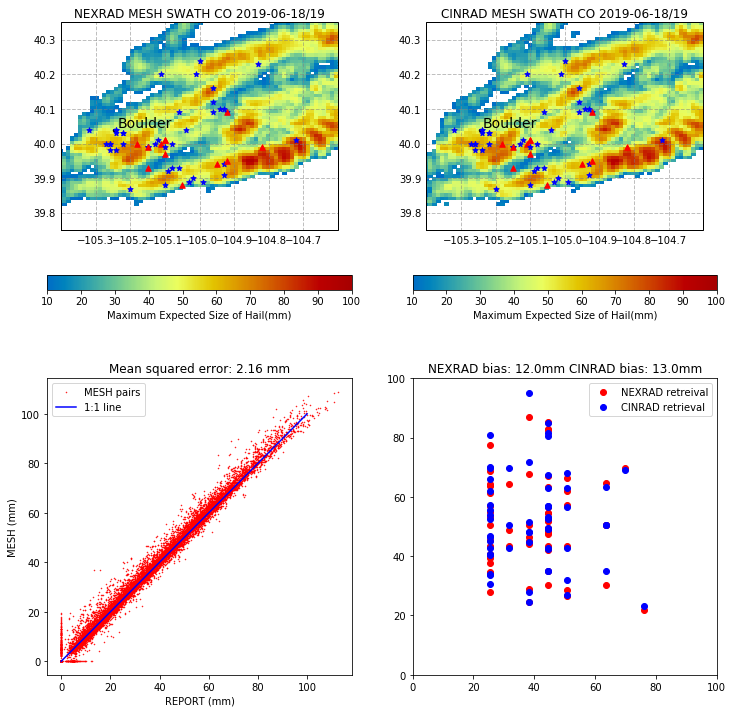

In [107]:
#read accumulated mesh swaths into memory
accumulated_mesh_nexrad = pyart.io.read_grid('nexrad_mesh.nc')
accumulated_mesh_cinrad = pyart.io.read_grid('cinrad_mesh.nc')

#call plotter
plotter_manager(accumulated_mesh_nexrad, accumulated_mesh_cinrad, 'MESH', 0, report_dict)  

In [ ]:
"""
s3 command used to download NEXRAD vols: aws s3 cp s3://noaa-nexrad-level2/2018/06/18/KFTG/ . --recursive

cinrad tilts:
0:0.5 (match)
1:1.5 (close)
2:2.4 (match)
3:3.4 (close)
4:4.3 (close)
5:6.0 (1.4 deg out either side)
6:9.9 (1 deg)
7:14.6 (1.3 deg out)
8:19.5 (1.6 deg out)

#cinrad radar config
bw: 0.7, sampled every 0.7
range bins: 300m to 150km

US tilts:
VCP 12/212/112: 0.5, 0.9, 1.3, 1.8, 2.4, 3.1, 4, 5.1, 6.4, 8, 10, 12.5, 15.6, 19.5 
VCP 215: 0.5, 0.9, 1.3, 1,8, 2.4, 3.1, 4, 5.1, 6.4, 8, 10, 12, 14, 16.7, 19.5 
VCP 121: 0.5, 1.5, 2.4, 3.4, 4.3, 6, 9.9, 14.6, 19.5 
VCP 31/32: 0.5, 1.5, 2.4, 3.4, 4.3 
VCP 35: 0.5, 0.9, 1.3, 1,8, 2.4, 3.1, 4, 5.1, 6.4
CINRAD VCP = US VCP 121

#NEXRAD radar config
bw: 0.925 (sampled at 0.5 deg)
gate: 250m to 300km

https://www.weather.gov/jetstream/vcp_max
"""